In [1]:
import sys
import time
import os
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from io import BytesIO

sns.set_theme(style="white")

# Link Interaction Data Insights

To create a Graph Neural Network (GNN) we will a way to link two nodes (genes) with one another. For now, we have investigated and developed candidate node-level features. In this notebook we will investigate how we can find linking information for genes.

In [59]:
!pwd
!find ../../datasets/string/ -ls

/Users/cwoest/Documents/Academics/Data_Science_UP/master_thesis/material/GNN-material
38944496        0 drwxr-xr-x    5 cwoest           staff                 160 Jun 29 11:42 ../../datasets/string/
38944659       24 -rw-r--r--    1 cwoest           staff                8196 Jun 29 11:42 ../../datasets/string//.DS_Store
38709030   225680 -rw-r--r--    1 cwoest           staff            115547735 Jun  9 16:28 ../../datasets/string//9606.protein.links.detailed.v11.5.txt.gz
38944498     3720 -rw-r--r--    1 cwoest           staff             1901833 Jun 29 11:09 ../../datasets/string//9606.protein.info.v11.5.txt.gz


According to [this description](https://string-db.org/network/9606.ENSP00000379496) of the STRING database the database contains the following informations.

<ins>__Nodes__:</ins> 
> Network nodes represent proteins.
- _splice isoforms or post-translational modifications are collapsed, i.e. each node represents all the proteins produced by a single, protein-coding gene locus._

<ins>__Edges__:</ins>
> Edges represent protein-protein associations.
- _associations are meant to be specific and meaningful, i.e. proteins jointly contribute to a shared function; this does not necessarily mean they are physically binding to each other._
- __Known Interactions__
  - _from curated databases_ (`database`)
  - _experimentally determined_ (`experimental`)
- __Predicted Interactions__
  - _gene neighborhood_ (`neighborhood`)
  - _gene fusions_ (`fusion`)
  - _gene co-occurence_ (`cooccurence`)
- __Others__
  - _textmining_ (`textmining`)
  - _co-expression_ (`coexpression`)
  - _protein homology_

In [2]:
PATH_TO_LINKING_DATA = '../../datasets/string/'
PATH_TO_SAVE_DATA_TO = '../../datasets/string/my_datasets/'

PROTEIN_LINKS_FILE = '9606.protein.links.detailed.v11.5.txt.gz'
PROTEIN_INFO_FILE = '9606.protein.info.v11.5.txt.gz'


---

## Landmark Genes

In [ ]:
PATH_TO_GDSC_DATASETS = '../../datasets/gdsc/'
FILENAME_LANDMARK_GENES = 'landmark_genes.csv' 

start = time.time()
landmark_genes = pd.read_csv(f'{PATH_TO_GDSC_DATASETS}{FILENAME_LANDMARK_GENES}', sep="\t")
print(f"File `{FILENAME_LANDMARK_GENES}` took {time.time()-start:.5f} seconds to import. It has shape {landmark_genes.shape}")
landmark_genes.head(3)

File `landmark_genes.csv` took 0.05927 seconds to import. It has shape (978, 7)


,Entrez ID,Symbol,Name,Gene Family,Type,RNA-Seq Correlation,RNA-Seq Correlation Self-Rank
0,3638,INSIG1,insulin induced gene 1,NaN,landmark,NaN,NaN
1,2309,FOXO3,forkhead box O3,Forkhead boxes,landmark,NaN,NaN
2,1001,CDH3,cadherin 3,Type I classical cadherins,landmark,NaN,NaN


In [ ]:
# Add a unique number (index) for each distinct landmark gene. 
# This will be used as an index for the node in the graph instead of the raw 
# gene symbol name.
UNIQ_LANDMARK_GENES = landmark_genes.reset_index()[['index', 'Symbol']].drop_duplicates()
UNIQ_LANDMARK_GENES.to_csv(f'{PATH_TO_SAVE_DATA_TO}uniq_landmark_genes_with_index.csv', sep=',', header=True, index=False)
print(f"Unique landmark genes with an index were written to ´{PATH_TO_SAVE_DATA_TO}uniq_landmark_genes_with_index.csv´.")
UNIQ_LANDMARK_GENES = pd.read_csv(f'{PATH_TO_SAVE_DATA_TO}uniq_landmark_genes_with_index.csv', sep=',')
UNIQ_LANDMARK_GENES.head(5)

Unique landmark genes with an index were written to ´../../datasets/string/my_datasets/uniq_landmark_genes_with_index.csv´.


,index,Symbol
0,0,INSIG1
1,1,FOXO3
2,2,CDH3
3,3,ORC1
4,4,ITGAE


## Linking Data

In [3]:
# ----------------- #
# Read Linking Data
# ----------------- #

# Read content of .gz file as bytes.
contents = gzip.open(f'{PATH_TO_LINKING_DATA}{PROTEIN_LINKS_FILE}', "rb").read()

# Convert bytes to pd.DataFrame.
data = BytesIO(contents)
protein_links_v1 = pd.read_csv(data, sep=' ')

print(protein_links_v1.shape)
protein_links_v1.head(5)

(11938498, 10)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,9606.ENSP00000000233,9606.ENSP00000379496,0,0,0,54,0,0,144,155
1,9606.ENSP00000000233,9606.ENSP00000314067,0,0,0,0,180,0,61,197
2,9606.ENSP00000000233,9606.ENSP00000263116,0,0,0,62,152,0,101,222
3,9606.ENSP00000000233,9606.ENSP00000361263,0,0,0,0,161,0,64,181
4,9606.ENSP00000000233,9606.ENSP00000409666,0,0,0,82,213,0,72,270


| Column | Description |
| ------ | ----------- | 
| `neighboorhood` | |
| `fusion` | |
| `cooccurence` | |
| `coexpression` | |
| `experimental` | |
| `database` | |
| `textmining` | |
| `combined_score` | |

- The data holds interaction information about two proteins.
- `9606`: The taxonomy ID of Homo Sapiens (https://www.ncbi.nlm.nih.gov/protein?term=txid9606[Organism]).'

In [4]:
protein_links_v1.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
count,11938498.00,11938498.00,11938498.00,11938498.00,11938498.00,11938498.00,11938498.00,11938498.00
mean,3.20,0.16,0.88,62.38,68.92,24.14,180.26,280.01
std,20.39,7.57,13.41,96.64,119.62,132.79,152.82,167.39
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,150.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,67.00,175.00
50%,0.00,0.00,0.00,54.00,0.00,0.00,161.00,216.00
75%,0.00,0.00,0.00,76.00,129.00,0.00,241.00,309.00
max,385.00,900.00,448.00,999.00,999.00,900.00,997.00,999.00


In [5]:
# ---------------------- #
# Read Protein Info Data
# ---------------------- #

# Read content of .gz file as bytes.
contents = gzip.open(f'{PATH_TO_LINKING_DATA}{PROTEIN_INFO_FILE}', "rb").read()

# Convert bytes to pd.DataFrame.
data = BytesIO(contents)
protein_info_v1 = pd.read_csv(data, sep='\t')

print(protein_info_v1.shape)
protein_info_v1.head(5)

(19566, 4)


,#string_protein_id,preferred_name,protein_size,annotation
0,9606.ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,9606.ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,9606.ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...
3,9606.ENSP00000001146,CYP26B1,512,Cytochrome P450 26B1; Involved in the metaboli...
4,9606.ENSP00000002125,NDUFAF7,441,"Protein arginine methyltransferase NDUFAF7, mi..."


| Column              | Description | Example |
| ------------------- | ----------- | ------- |
| `string_protein_id` | Protein identifier | `9606.ENSP00000000233	` |
| `preferred_name`    | Gene identifier. Same as `GENE_SYMBOL`. | `M6PR` |
| `protein_size`      | Size of the protein in aa (amino acids)| `277` |
| `annotation`        | Full name of the protein. | `Cation-dependent mannose-6-phosphate receptor;...` |

- The `string_protein_id` protein is encoded by the `preferred_name` gene
- The `preferred_name` gene encodes the `string_protein_id` protein
- `9606` stands for the taxonomy ID of Homo Sapiens (https://www.ncbi.nlm.nih.gov/protein?term=txid9606[Organism]).'

---
## Data Wrangling

### Protein Links

In [6]:
# Exclude the Homo Sapiens taxonomy ID from the protein columns.
protein_links_v2 = protein_links_v1.copy()
protein_links_v2.protein1 = protein_links_v2.protein1.str[5:]
protein_links_v2.protein2 = protein_links_v2.protein2.str[5:]
protein_links_v2.head(3)

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222


### Protein Info

In [7]:
# Rename protein identifier column.
protein_info_v2 = protein_info_v1.rename(columns={'#string_protein_id': 'string_protein_id'}, inplace=False)

# Exclude the Homo Sapiens taxonomy ID from the protein columns.
protein_info_v2.string_protein_id = protein_info_v2.string_protein_id.str[5:]
protein_info_v2.head(3)

,string_protein_id,preferred_name,protein_size,annotation
0,ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...


---
## Understanding The Data

> Are the `preferred_name`´s in the protein info data the genes which direct the production of the proteins?

In [8]:
# -------------------------------------------------------------------- #
# Get the landmark genes which define the set of genes which were used
# in the previous notebooks to create candidate features.
# -------------------------------------------------------------------- #

PATH_TO_GDSC_DATASETS = '../../datasets/gdsc/'
FILENAME_LANDMARK_GENES = 'landmark_genes.csv' 

start = time.time()
landmark_genes = pd.read_csv(f'{PATH_TO_GDSC_DATASETS}{FILENAME_LANDMARK_GENES}', sep="\t")
print(f"File `{FILENAME_LANDMARK_GENES}` took {time.time()-start:.5f} seconds to import. It has shape {landmark_genes.shape}")
landmark_genes.head(3)

File `landmark_genes.csv` took 0.00588 seconds to import. It has shape (978, 7)


,Entrez ID,Symbol,Name,Gene Family,Type,RNA-Seq Correlation,RNA-Seq Correlation Self-Rank
0,3638,INSIG1,insulin induced gene 1,NaN,landmark,NaN,NaN
1,2309,FOXO3,forkhead box O3,Forkhead boxes,landmark,NaN,NaN
2,1001,CDH3,cadherin 3,Type I classical cadherins,landmark,NaN,NaN


In [9]:
# Check if the 'Symbol'´s can be found in the 'preferred_name'´s of the protein info data.
uniq_preferred_names = np.unique(protein_info_v2.preferred_name.values)
uniq_landmark_genes = np.unique(landmark_genes.Symbol.values)
count = sum(v in landmark_genes.Symbol.values for v in protein_info_v2.preferred_name.values)
print(f"Out of {len(uniq_preferred_names)} unique ´preferred_name´s in the protein info data {count} can also be found in the {len(uniq_landmark_genes)} unique landmark genes.")
print(f"Thus, {round(100*count/len(uniq_landmark_genes), 2)}% of all unique landmark genes are existent in the protein info data.")

Out of 19563 unique ´preferred_name´s in the protein info data 965 can also be found in the 978 unique landmark genes.
Thus, 98.67% of all unique landmark genes are existent in the protein info data.


__Conclusion__: 
- We validated that the `preferred_name` is standing for the specific gene, which was called `GENE_SYMBOL` in other notebooks or `Symbol` in the landmark gene dataset respectively.
- We can map the `preferred_name` (gene symbol) of the protein info dataset to the protein link dataset to get the corresponding gene per protein. 
  - This way we map a protein-protein interaction to the corresponding gene-gene interaction.

---

## Mapping Of Genes To Proteins

In [10]:
protein_info_v2.head(3)

,string_protein_id,preferred_name,protein_size,annotation
0,ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...


In [11]:
protein_links_v2.head(3)

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222


In [12]:
# ------------------------------------------------------------------------ #
# Map the corresponding genes to the proteins in the protein link dataset.
# ------------------------------------------------------------------------ #
# Get the gene symbols for the protein1 column.
protein_links_v3 = protein_links_v2.merge(right    = protein_info_v2[['string_protein_id', 'preferred_name']],
                                          how      = 'left',
                                          left_on  = 'protein1',
                                          right_on = 'string_protein_id')
protein_links_v3.rename(columns={'preferred_name': 'gene_symbol1'}, inplace=True)
protein_links_v3.drop(['string_protein_id'], axis=1, inplace=True)

# Get the gene symbols for the protein2 column.
protein_links_v4 = protein_links_v3.merge(right    = protein_info_v2[['string_protein_id', 'preferred_name']],
                                          how      = 'left',
                                          left_on  = 'protein2',
                                          right_on = 'string_protein_id')
protein_links_v4.rename(columns={'preferred_name': 'gene_symbol2'}, inplace=True)
protein_links_v4.drop(['string_protein_id'], axis=1, inplace=True)

print(f"""
    Shape:
        before joining : {protein_links_v2.shape}
        after  joining : {protein_links_v4.shape}
""")                                                                                  
protein_links_v4.head(5)



    Shape:
        before joining : (11938498, 10)
        after  joining : (11938498, 12)



,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155,ARF5,PDE1C
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197,ARF5,PAK2
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222,ARF5,RAB36
3,ENSP00000000233,ENSP00000361263,0,0,0,0,161,0,64,181,ARF5,RAPGEF1
4,ENSP00000000233,ENSP00000409666,0,0,0,82,213,0,72,270,ARF5,SUMO3


In [13]:
# Check if for any protein there hasn't been found a correspoding gene (symbol).
protein_links_v4[['gene_symbol1', 'gene_symbol2']].isna().sum()

gene_symbol1    0
gene_symbol2    0
dtype: int64

---

## EDA

- [ ] How many different genes are in the protein linking table (to estimate the maximal size of the graph)?
- [ ] How many different gene-gene interactions are there? 

In [14]:
# Unique number of genes per column.
uniq_gene1 = np.unique(protein_links_v4.gene_symbol1.values)
uniq_gene2 = np.unique(protein_links_v4.gene_symbol2.values)

print(f"""
    There are 
        {len(uniq_gene1)} unique gene_symbol1
        {len(uniq_gene2)} unique gene_symbol2
""")


    There are 
        19382 unique gene_symbol1
        19382 unique gene_symbol2



In [18]:
# Unique number of gene-gene combinations.
freq_per_tuple = protein_links_v4.groupby(['gene_symbol1', 'gene_symbol2']).size().reset_index(name='freq', inplace=False).sort_values(['freq'], ascending=False)
freq_per_tuple.groupby(['freq']).size().reset_index(name='count', inplace=False)

,freq,count
0,1,11936220
1,2,1139


- Some `(gene_symbol1, gene_symbol2)` tuples occur two times.
- However, the majority occurs only one time.

---

## Sparse Linking Dataset Using Landmark genes

- [ ] Sparse down the linking dataset by only using rows where both, `gene_symbol1` and `gene_symbol2` are in the set of landmark genes.

In [248]:
print(f"Shape: {protein_links_v4.shape}")
protein_links_v4.head(3)

Shape: (11938498, 12)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155,ARF5,PDE1C
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197,ARF5,PAK2
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222,ARF5,RAB36


In [247]:
UNIQ_LANDMARK_GENES.head(3)

,index,Symbol
0,0,INSIG1
1,1,FOXO3
2,2,CDH3


In [256]:
protein_links_v5_sparsed = protein_links_v4.loc[(protein_links_v4.gene_symbol1.isin(UNIQ_LANDMARK_GENES.Symbol)) & 
                                                (protein_links_v4.gene_symbol2.isin(UNIQ_LANDMARK_GENES.Symbol))]
n_rows = protein_links_v5_sparsed.shape[0]
perc_kept = 100*n_rows/protein_links_v4.shape[0]
print(f"""After filtered down such that both columns ´gene_symbol1´ and ´gene_symbol2´ are landmark genes the shape is {n_rows} ({perc_kept:2.2f} %). 
This means {protein_links_v4.shape[0]-protein_links_v5_sparsed.shape[0]} have either one or both gene symbols not in the set of {UNIQ_LANDMARK_GENES.shape[0]} landmark genes.
""")

After filtered down such that both columns ´gene_symbol1´ and ´gene_symbol2´ are landmark genes the shape is 102632 (0.86 %). 
This means 11835866 have either one or both gene symbols not in the set of 978 landmark genes.



---
## Add Node Index To DataFrame

The simplify the building of a gene-gene interaction graph in the further process of the notebook we are going to assign an index for each unique `gene_symbol`. This index will then hold as an identifier for a node (gene) in the graph.

In [257]:
protein_links_v5_sparsed.head(3)

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2
1940,ENSP00000001008,ENSP00000408295,0,0,0,81,0,0,258,288,FKBP4,RFC5
1941,ENSP00000001008,ENSP00000241337,0,0,0,62,175,0,71,218,FKBP4,GSTM2
1946,ENSP00000001008,ENSP00000440485,0,0,0,91,176,0,129,290,FKBP4,PSMD9


In [265]:
# Append corresponding index for each gene symbol column as new column(s).
protein_links_v6_indexed = protein_links_v5_sparsed.merge(right    = UNIQ_LANDMARK_GENES,
                                                          how      = 'left',
                                                          left_on  = ['gene_symbol1'],
                                                          right_on = ['Symbol'])
protein_links_v6_indexed.rename(columns={'index': 'index_gene_symbol1'}, inplace=True)
protein_links_v6_indexed.drop(['Symbol'], axis=1, inplace=True)

protein_links_v7_indexed = protein_links_v6_indexed.merge(right    = UNIQ_LANDMARK_GENES,
                                                          how      = 'left',
                                                          left_on  = ['gene_symbol2'],
                                                          right_on = ['Symbol'])
protein_links_v7_indexed.rename(columns={'index': 'index_gene_symbol2'}, inplace=True)
protein_links_v7_indexed.drop(['Symbol'], axis=1, inplace=True)

protein_links_v7_indexed.head(3)                                                        

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2,index_gene_symbol1,index_gene_symbol2
0,ENSP00000001008,ENSP00000408295,0,0,0,81,0,0,258,288,FKBP4,RFC5,970,910
1,ENSP00000001008,ENSP00000241337,0,0,0,62,175,0,71,218,FKBP4,GSTM2,970,215
2,ENSP00000001008,ENSP00000440485,0,0,0,91,176,0,129,290,FKBP4,PSMD9,970,846


---
## Build Graph

In [341]:
# Set of unique gene symbols.
nodes = np.unique(protein_links_v7_indexed[['gene_symbol1', 'gene_symbol2']].values)
print(f"There will be {len(nodes)} nodes in the graph.")

nodes_as_indices = np.unique(protein_links_v7_indexed[['index_gene_symbol1', 'index_gene_symbol2']].values)
print(f"There will be {len(nodes_as_indices)} indices in the graph.")

There will be 965 nodes in the graph.
There will be 965 indices in the graph.


In [291]:
# Create a list of tuples which hold neighbor nodes.
gene_symbol_tuples = list(set(list(zip(protein_links_v7_indexed.gene_symbol1, protein_links_v7_indexed.gene_symbol2))))
print(gene_symbol_tuples[:5])


# Map the list of tuples of neighbor gene nodes to the corresponding int. 
transform_gene_tuple_to_index_tuple = lambda x : [UNIQ_LANDMARK_GENES[UNIQ_LANDMARK_GENES.Symbol==x[0]]['index'].values[0], 
                                                  UNIQ_LANDMARK_GENES[UNIQ_LANDMARK_GENES.Symbol==x[1]]['index'].values[0]]
input_vec = [transform_gene_tuple_to_index_tuple(tup) for tup in gene_symbol_tuples]
print(input_vec[:5])

[('SMAD3', 'CCNB2'), ('TP53', 'PTPN6'), ('CDK4', 'KDELR2'), ('HSPA4', 'PYCR1'), ('POLR1C', 'RAE1')]
[[748, 311], [460, 856], [8, 37], [902, 872], [393, 462]]


In [292]:
# Find neighbors using the gene symbols.
dict_as_genes = {gene_node: [] for gene_node in nodes}  # or dict(zip(nodes, []*len(nodes)))

# Get the edges.
for gene in dict_as_genes:
    exists_in_gene_symbol1 = not protein_links_v7_indexed.loc[protein_links_v7_indexed.gene_symbol1==gene].empty
    exists_in_gene_symbol2 = not protein_links_v7_indexed.loc[protein_links_v7_indexed.gene_symbol2==gene].empty

    neighbor_nodes = None 
    if exists_in_gene_symbol1:
        neighbor_nodes = list(set(protein_links_v7_indexed.loc[protein_links_v7_indexed.gene_symbol1==gene].gene_symbol2))
    elif exists_in_gene_symbol2: 
        neighbor_nodes = list(set(protein_links_v7_indexed.loc[protein_links_v7_indexed.gene_symbol2==gene].gene_symbol1))
    else: 
        print(f"The gene {gene} couldn't be found in the dataset!") 

    # Set neighbors for the gene.
    dict_as_genes[gene] += [neighbor_node for neighbor_node in neighbor_nodes if neighbor_node not in dict_as_genes[gene]]

In [295]:
len(dict_as_genes['AARS'])

140

In [307]:
# Find neighbors using the indices.
dict_as_indices = {gene_node: [] for gene_node in nodes_as_indices}  # or dict(zip(nodes, []*len(nodes)))

# Get the edges.
for gene in dict_as_indices:
    exists_in_gene_symbol1 = not protein_links_v7_indexed.loc[protein_links_v7_indexed.index_gene_symbol1==gene].empty
    exists_in_gene_symbol2 = not protein_links_v7_indexed.loc[protein_links_v7_indexed.index_gene_symbol2==gene].empty

    neighbor_nodes = None 
    if exists_in_gene_symbol1:
        neighbor_nodes = list(set(protein_links_v7_indexed.loc[protein_links_v7_indexed.index_gene_symbol1==gene].index_gene_symbol2))
    elif exists_in_gene_symbol2: 
        neighbor_nodes = list(set(protein_links_v7_indexed.loc[protein_links_v7_indexed.index_gene_symbol2==gene].index_gene_symbol1))
    else: 
        print(f"The gene {gene} couldn't be found in the dataset!") 

    # Set neighbors for the gene.
    dict_as_indices[gene] += [neighbor_node for neighbor_node in neighbor_nodes if neighbor_node not in dict_as_indices[gene]]

In [323]:
# How many neighbors are there on average?
len_of_neighbors = [len(neighbors) for _, neighbors in dict_as_indices.items()]
assert len(len_of_neighbors) == len(nodes)
print(f"On average there are {np.mean(len_of_neighbors):5.0f} neighbors per node.")

On average there are   106 neighbors per node.


In [326]:
# Map the list of tuples of neighbor gene nodes to the corresponding int.
input_vec[:5]

[[748, 311], [460, 856], [8, 37], [902, 872], [393, 462]]

In [328]:
import itertools
# Flatten the list
merged = list(itertools.chain(*input_vec))
merged[:5]

[748, 311, 460, 856, 8]

In [329]:
counts = pd.Series(merged).value_counts().to_frame(name='count').sort_index()
counts[:5]

,count
0,156
1,576
2,196
3,290
4,136


In [330]:
# ------------------------------------------------------------ #
# Create a torch_geometric Data class using the mapped numbers.
# ------------------------------------------------------------ #
import torch 
from torch_geometric.data import Data

edge_index = torch.tensor(input_vec, dtype=torch.long)  # All neighbor tuples.
x = torch.tensor(counts.values, dtype=torch.float)      # Per index (node/gene) the number of neighbors. 

data = Data(x          = x, 
            edge_index = edge_index.t().contiguous())
data

Data(x=[965, 1], edge_index=[2, 102632])

- `x`: $965$ distinct nodes with each $1$ node feature, which is the number of neighbors.
- `edge_index`: $102,632$ links with each link having a start- and an end-node.

In [340]:
# Checking some utility functions.
print(f"""
    data.num_nodes          : {data.num_nodes}
    data.num_edges          : {data.num_edges}
    data.num_node_features  : {data.num_node_features}
    data.num_edge_features  : {data.num_edge_features}
    data.has_isolated_nodes : {data.has_isolated_nodes()}
    data.has_self_loops     : {data.has_self_loops()}
    data.is_directed        : {data.is_directed()}
""")


    data.num_nodes          : 965
    data.num_edges          : 102632
    data.num_node_features  : 1
    data.num_edge_features  : 0
    data.has_isolated_nodes : False
    data.has_self_loops     : False
    data.is_directed        : True



---
## Model Each Cell-Line As A Graph
### Add Nodes-Level Features
Each `CELL_LINE_NAME` has one specific node feature value. For example the gene expression level, the copy number or mutational information. Thus, 
- we can build a graph per cell-line and 
- add the node feature to each gene node.

Note that each graph will have the exact same structure. Meaning, each graph will have the same nodes, only the node values differ. In total there will be $N_{cl}$ graph where $N_{cl}$ stands for the number of distinct cell-lines.

The objective is to have a feature vector per node/gene of the form $g_n = [v_{mRnaExpr}, v_{CNV}, v_{isMutated}]$, where 
- $v_{mRnaExpr}$ holds the value of gene expression
- $v_{CNV}$ holds the value of copy numbers
- $v_{isMutated}$ holds the value if it mutated or not.

In [381]:
from my_utils import (
    PATH_TO_SAVE_NODE_FEATURE_DATA_TO,
    GENE_EXPR_FINAL_FILE_NAME,
    CNV_GISTIC_FINAL_FILE_NAME,
    CNV_PICNIC_FINAL_FILE_NAME
)

In [355]:
# ------------------------------------------- #
# GENE EXPRESSION
# Read the final gene expression dataset from 
# notebook 02_GDSC_map_GenExpr.ipynb.
# ------------------------------------------- #
gene_expr = pd.read_pickle(f'{PATH_TO_SAVE_NODE_FEATURE_DATA_TO}{GENE_EXPR_FINAL_FILE_NAME}')
print(gene_expr.shape)
print(f"Number of unique cell-line & thus number of graph which will be created: {len(np.unique(gene_expr.CELL_LINE_NAME.values))}.")
print(f"Number of gene columns: {len(gene_expr.columns[14:])}")
gene_expr.head(3)

(446521, 922)
Number of unique cell-line & thus number of graph which will be created: 988.
Number of gene columns: 908


,DRUG_ID,CELL_LINE_NAME,AUC,CELL_ID,LN_IC50,CONC,MASTER_CELL_ID,INTENSITY,DATASET,Z_SCORE,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
0,1,MC-CAR,0.982114,3137,2.395685,2.0,49,544404,GDSC1,-0.189576,...,8.355826,8.951680,7.205590,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
9,1,ES3,0.984816,2366,3.140923,2.0,1342,404197,GDSC1,0.508635,...,5.995760,9.337588,7.468226,3.716270,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
27,1,ES5,0.985693,2368,3.968757,2.0,610,797378,GDSC1,1.284229,...,6.939741,8.688176,7.085349,3.688222,4.572119,6.345090,12.276166,4.114092,5.768098,7.505155


In [382]:
# ---------------------------------------- #
# COPY NUMBER VARIATION
# Read the final cnv dataset from notebook
# 03_GDSC_map_CNV.ipynb.
# ---------------------------------------- #
# Copy number variation gistic final dataset.
final_cnv_gistic = pd.read_pickle(f'{PATH_TO_SAVE_NODE_FEATURE_DATA_TO}{CNV_GISTIC_FINAL_FILE_NAME}')
print(f"CNV Gistic: {final_cnv_gistic.shape}")

# Copy number variation picnic final dataset.
final_cnv_picnic = pd.read_pickle(f'{PATH_TO_SAVE_NODE_FEATURE_DATA_TO}{CNV_PICNIC_FINAL_FILE_NAME}')
print(f"CNV Picnic: {final_cnv_picnic.shape}")

CNV Gistic: (446521, 952)
CNV Picnic: (446521, 980)


In [348]:
gene_expr.loc[gene_expr.CELL_LINE_NAME=='ES3']

,DRUG_ID,CELL_LINE_NAME,AUC,CELL_ID,LN_IC50,CONC,MASTER_CELL_ID,INTENSITY,DATASET,Z_SCORE,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
9,1,ES3,0.984816,2366,3.140923,2.0,1342,404197,GDSC1,0.508635,...,5.99576,9.337588,7.468226,3.71627,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
4572,3,ES3,0.981415,2366,-0.067752,0.1,1342,561199,GDSC1,1.120134,...,5.99576,9.337588,7.468226,3.71627,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
8622,5,ES3,0.941416,2366,3.043634,8.0,1342,277899,GDSC1,0.330702,...,5.99576,9.337588,7.468226,3.71627,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
12852,6,ES3,0.981549,2366,2.935678,2.0,1342,524262,GDSC1,0.223649,...,5.99576,9.337588,7.468226,3.71627,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
17487,9,ES3,0.956082,2366,1.296998,1.0,1342,398551,GDSC1,0.947409,...,5.99576,9.337588,7.468226,3.71627,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386931,1502,ES3,0.974498,2366,4.199460,10.0,1342,2146522,GDSC1,-0.369485,...,5.99576,9.337588,7.468226,3.71627,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
3392246,1526,ES3,0.963667,2366,3.119137,5.0,1342,1827393,GDSC1,0.871292,...,5.99576,9.337588,7.468226,3.71627,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
3397456,1527,ES3,0.816016,2366,0.807811,4.0,1342,950337,GDSC1,-0.014279,...,5.99576,9.337588,7.468226,3.71627,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
3402698,1529,ES3,0.818002,2366,-0.561027,1.0,1342,274514,GDSC1,-0.483495,...,5.99576,9.337588,7.468226,3.71627,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201


In [ ]:
# Construct graph for each cell-line. Set corresponding gene-expression values per node. 
# Graph predicts IC50 value. However, IC50 value obviously different for each DRUG_ID. 
#  

In [349]:
PATH_TO_GDSC_SCREENING_DATA = '../../datasets/gdsc/screening_data/'
GDSC1_IC50_FILE = 'GDSC1_fitted_dose_response_25Feb20.xlsx'
gdsc1_ic50s = pd.read_excel(f'{PATH_TO_GDSC_SCREENING_DATA}{GDSC1_IC50_FILE}', header=0)

In [350]:
gdsc1_ic50s.loc[gdsc1_ic50s.CELL_LINE_NAME=='ES3']

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
1,GDSC1,281,12975300,684055,ES3,SIDM00265,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,3.140923,0.984816,0.031840,0.508635
395,GDSC1,281,12975551,684055,ES3,SIDM00265,UNCLASSIFIED,3,Rapamycin,MTORC1,PI3K/MTOR signaling,1045,Y,0.000391,0.1,-0.067752,0.981415,0.074930,1.120134
753,GDSC1,281,12975618,684055,ES3,SIDM00265,UNCLASSIFIED,5,Sunitinib,"PDGFR, KIT, VEGFR, FLT3, RET, CSF1R",RTK signaling,1045,Y,0.031250,8.0,3.043634,0.941416,0.023747,0.330702
1151,GDSC1,281,12975633,684055,ES3,SIDM00265,UNCLASSIFIED,6,PHA-665752,MET,RTK signaling,1045,Y,0.007813,2.0,2.935678,0.981549,0.057955,0.223649
1558,GDSC1,281,12975644,684055,ES3,SIDM00265,UNCLASSIFIED,9,MG-132,"Proteasome, CAPN1",Protein stability and degradation,1045,Y,0.003906,1.0,1.296998,0.956082,0.020726,0.947409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306729,GDSC1,281,12975447,684055,ES3,SIDM00265,UNCLASSIFIED,1502,Bicalutamide,AR,Hormone-related,1046,Y,0.039063,10.0,4.199460,0.974498,0.056111,-0.369485
307604,GDSC1,281,12975450,684055,ES3,SIDM00265,UNCLASSIFIED,1526,Refametinib,"MEK1, MEK2",ERK MAPK signaling,1046,Y,0.019531,5.0,3.119137,0.963667,0.107487,0.871292
308478,GDSC1,281,12975451,684055,ES3,SIDM00265,UNCLASSIFIED,1527,Pictilisib,PI3K (class 1),PI3K/MTOR signaling,1046,Y,0.015625,4.0,0.807811,0.816016,0.069947,-0.014279
309358,GDSC1,281,12975452,684055,ES3,SIDM00265,UNCLASSIFIED,1529,Pevonedistat,NAE,Other,1046,Y,0.003906,1.0,-0.561027,0.818002,0.159992,-0.483495


In [290]:
input_vec = [transform_gene_tuple_to_index_tuple(tup) for tup in gene_symbol_tuples[:5]]
input_vec

[[748, 311], [460, 856], [8, 37], [902, 872], [393, 462]]

In [ ]:
# Map the list of tuples of neighbor gene nodes to the corresponding int. 
transform_gene_tuple_to_index_tuple = lambda x : [mapping_gene_to_number[x[0]], mapping_gene_to_number[x[1]]]
input_vec = [transform_gene_tuple_to_index_tuple(tup) for tup in t]
input_vec

[[4, 1], [2, 7], [15, 9], [12, 13], [14, 8], [5, 1], [11, 0], [5, 6], [3, 10]]

In [ ]:
mapping_index_to_gene = dict(zip(nodes_as_numbers, nodes))
mapping_gene_to_index = dict(zip(nodes, nodes_as_numbers))
mapping_number_to_gene

---
## Build Graph Only By Connection Or Not

- For now, build a graph only using the information if there is an existing tuple in the dataset or not.
- The graph will be undirected.

In [40]:
test.iloc[0].tolist()

['ENSP00000394168',
 'ENSP00000357308',
 0,
 0,
 0,
 0,
 0,
 0,
 303,
 303,
 'SLCO1B7',
 'CENPW']

In [120]:
SEED = 42
SAMPLE_SIZE = 8

# Random sample some rows for testing purposes, to get some distinct gene-gene tuples.
test = protein_links_v4.sample(SAMPLE_SIZE, random_state=SEED)

# For testing purposes duplicate a row.
sample = test.sample(1, random_state=SEED)
test = pd.concat([test, sample], ignore_index=True)
test = pd.concat([test, sample], ignore_index=True)

test.loc[test.shape[0]-3, 'gene_symbol2'] = 'KLHL28'  # Case where the tuple (gene1, gene2) already exists.
test.loc[test.shape[0]-2, 'gene_symbol2'] = 'CFL1'
test.loc[test.shape[0]-1, 'gene_symbol2'] = 'KCNG2'   # Case where gene1 and gene2 are the same.

test

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2
0,ENSP00000394168,ENSP00000357308,0,0,0,0,0,0,303,303,SLCO1B7,CENPW
1,ENSP00000315654,ENSP00000379434,0,0,0,0,0,0,284,284,KCNG2,KLHL28
2,ENSP00000351108,ENSP00000432660,0,0,0,121,0,0,104,178,HNRNPAB,CFL1
3,ENSP00000361803,ENSP00000361852,0,0,0,0,0,0,565,565,SMAP2,TMCO2
4,ENSP00000365435,ENSP00000308938,0,0,0,53,0,0,151,161,TNFRSF1B,PLG
5,ENSP00000396402,ENSP00000341243,0,0,0,0,104,0,434,471,ZNF793,RBPJL
6,ENSP00000323901,ENSP00000328596,0,0,0,122,0,0,253,316,FZD2,SIX6
7,ENSP00000222982,ENSP00000312286,0,0,0,63,0,0,295,311,CYP3A5,PLA2G1B
8,ENSP00000315654,ENSP00000379434,0,0,0,0,0,0,284,284,KCNG2,KLHL28
9,ENSP00000315654,ENSP00000379434,0,0,0,0,0,0,284,284,KCNG2,CFL1


In [149]:
nodes = np.unique(test[['gene_symbol1', 'gene_symbol2']].values)
len(nodes)

16

In [154]:
nodes_as_numbers = np.arange(0, len(nodes), 1)
mapping_number_to_gene = dict(zip(nodes_as_numbers, nodes))
mapping_gene_to_number = dict(zip(nodes, nodes_as_numbers))
mapping_number_to_gene

{0: 'CENPW',
 1: 'CFL1',
 2: 'CYP3A5',
 3: 'FZD2',
 4: 'HNRNPAB',
 5: 'KCNG2',
 6: 'KLHL28',
 7: 'PLA2G1B',
 8: 'PLG',
 9: 'RBPJL',
 10: 'SIX6',
 11: 'SLCO1B7',
 12: 'SMAP2',
 13: 'TMCO2',
 14: 'TNFRSF1B',
 15: 'ZNF793'}

In [122]:
dict_as_genes = {gene_node: [] for gene_node in nodes}  # or dict(zip(nodes, []*len(nodes)))
len(dict_as_genes)

16

In [137]:
dict_as_genes = {gene_node: [] for gene_node in nodes}  # or dict(zip(nodes, []*len(nodes)))

# Get the edges.
for gene in dict_as_genes:
    print(f"Checking gene : {gene}")
    exists_in_gene_symbol1 = not test.loc[test.gene_symbol1==gene].empty
    exists_in_gene_symbol2 = not test.loc[test.gene_symbol2==gene].empty

    neighbor_nodes = None 
    if exists_in_gene_symbol1:
        neighbor_nodes = list(set(test.loc[test.gene_symbol1==gene].gene_symbol2))
    elif exists_in_gene_symbol2: 
        neighbor_nodes = list(set(test.loc[test.gene_symbol2==gene].gene_symbol1))
    else: 
        print(f"The gene {gene} couldmn't be found in the dataset!") 

    # Set neighbors for the gene.
    #print(f"    appending neighbors {neighbor_nodes}")
    dict_as_genes[gene] += [neighbor_node for neighbor_node in neighbor_nodes if neighbor_node not in dict_as_genes[gene]]

Checking gene : CENPW
Checking gene : CFL1
Checking gene : CYP3A5
Checking gene : FZD2
Checking gene : HNRNPAB
Checking gene : KCNG2
Checking gene : KLHL28
Checking gene : PLA2G1B
Checking gene : PLG
Checking gene : RBPJL
Checking gene : SIX6
Checking gene : SLCO1B7
Checking gene : SMAP2
Checking gene : TMCO2
Checking gene : TNFRSF1B
Checking gene : ZNF793


In [138]:
dict_as_genes

{'CENPW': ['SLCO1B7'],
 'CFL1': ['KCNG2', 'HNRNPAB'],
 'CYP3A5': ['PLA2G1B'],
 'FZD2': ['SIX6'],
 'HNRNPAB': ['CFL1'],
 'KCNG2': ['CFL1', 'KLHL28'],
 'KLHL28': ['KCNG2'],
 'PLA2G1B': ['CYP3A5'],
 'PLG': ['TNFRSF1B'],
 'RBPJL': ['ZNF793'],
 'SIX6': ['FZD2'],
 'SLCO1B7': ['CENPW'],
 'SMAP2': ['TMCO2'],
 'TMCO2': ['SMAP2'],
 'TNFRSF1B': ['PLG'],
 'ZNF793': ['RBPJL']}

In [163]:
# ------------------------- #
# Map the genes to numbers.
# ------------------------- #

# Return dictionary as the mapped numbers.
dict_as_numbers = {mapping_gene_to_number[gene]: [mapping_gene_to_number[neighbor] for neighbor in neighbors] for gene, neighbors in dict_as_genes.items()}
dict_as_numbers

{0: [11],
 1: [5, 4],
 2: [7],
 3: [10],
 4: [1],
 5: [1, 6],
 6: [5],
 7: [2],
 8: [14],
 9: [15],
 10: [3],
 11: [0],
 12: [13],
 13: [12],
 14: [8],
 15: [9]}

---
## Transform to pytorch geometric graph

In [173]:
test[['gene_symbol1', 'gene_symbol2']]

,gene_symbol1,gene_symbol2
0,SLCO1B7,CENPW
1,KCNG2,KLHL28
2,HNRNPAB,CFL1
3,SMAP2,TMCO2
4,TNFRSF1B,PLG
5,ZNF793,RBPJL
6,FZD2,SIX6
7,CYP3A5,PLA2G1B
8,KCNG2,KLHL28
9,KCNG2,CFL1


In [181]:
# Create a list of tuples which hold neighbor nodes.
t = list(set(list(zip(test.gene_symbol1, test.gene_symbol2))))
t

[('HNRNPAB', 'CFL1'),
 ('CYP3A5', 'PLA2G1B'),
 ('ZNF793', 'RBPJL'),
 ('SMAP2', 'TMCO2'),
 ('TNFRSF1B', 'PLG'),
 ('KCNG2', 'CFL1'),
 ('SLCO1B7', 'CENPW'),
 ('KCNG2', 'KLHL28'),
 ('FZD2', 'SIX6')]

In [202]:
# Map the list of tuples of neighbor gene nodes to the corresponding int. 
transform_gene_tuple_to_index_tuple = lambda x : [mapping_gene_to_number[x[0]], mapping_gene_to_number[x[1]]]
input_vec = [transform_gene_tuple_to_index_tuple(tup) for tup in t]
input_vec

[[4, 1], [2, 7], [15, 9], [12, 13], [14, 8], [5, 1], [11, 0], [5, 6], [3, 10]]

In [204]:
import itertools
# Flatten the list
merged = list(itertools.chain(*input_vec))
merged

[4, 1, 2, 7, 15, 9, 12, 13, 14, 8, 5, 1, 11, 0, 5, 6, 3, 10]

In [218]:
counts = pd.Series(merged).value_counts().to_frame(name='count').sort_index()
counts

,count
0,1
1,2
2,1
3,1
4,1
5,2
6,1
7,1
8,1
9,1


In [222]:
counts.values

array([[1],
       [2],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [225]:
# ------------------------------------ #
# Create tensor which holds all tuples. 
# ------------------------------------ #
test

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2
0,ENSP00000394168,ENSP00000357308,0,0,0,0,0,0,303,303,SLCO1B7,CENPW
1,ENSP00000315654,ENSP00000379434,0,0,0,0,0,0,284,284,KCNG2,KLHL28
2,ENSP00000351108,ENSP00000432660,0,0,0,121,0,0,104,178,HNRNPAB,CFL1
3,ENSP00000361803,ENSP00000361852,0,0,0,0,0,0,565,565,SMAP2,TMCO2
4,ENSP00000365435,ENSP00000308938,0,0,0,53,0,0,151,161,TNFRSF1B,PLG
5,ENSP00000396402,ENSP00000341243,0,0,0,0,104,0,434,471,ZNF793,RBPJL
6,ENSP00000323901,ENSP00000328596,0,0,0,122,0,0,253,316,FZD2,SIX6
7,ENSP00000222982,ENSP00000312286,0,0,0,63,0,0,295,311,CYP3A5,PLA2G1B
8,ENSP00000315654,ENSP00000379434,0,0,0,0,0,0,284,284,KCNG2,KLHL28
9,ENSP00000315654,ENSP00000379434,0,0,0,0,0,0,284,284,KCNG2,CFL1


In [226]:
input_vec

[[4, 1], [2, 7], [15, 9], [12, 13], [14, 8], [5, 1], [11, 0], [5, 6], [3, 10]]

In [224]:
# ------------------------------------------------------------ #
# Create a torch_geometric Data class using the mapped numbers.
# ------------------------------------------------------------ #
import torch 
from torch_geometric.data import Data

edge_index = torch.tensor(input_vec, dtype=torch.long)
x = torch.tensor(counts.values, dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())
data

Data(x=[16, 1], edge_index=[2, 9])

In [139]:
# Resource: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
# >>> Data(edge_index=[2, 4], x=[3, 1])

data 

Data(x=[3, 1], edge_index=[2, 4])

In [142]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([['A'], ['B'], ['C']], dtype=torch.complex64)

data = Data(x=x, edge_index=edge_index)

ValueError: too many dimensions 'str'

In [59]:
# -------------------------------------------------------- #
# Build dictionary holding node (gene_symbol1) as the keys 
# and connected nodes (gene_symbol2) as the value.
# -------------------------------------------------------- #


36

In [82]:
protein_links_v2.merge(right=protein_info_v2[['string_protein_id', 'preferred_name']],
                                          how='left',
                                          left_on='protein1',
                                          right_on='string_protein_id')

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,string_protein_id,preferred_name
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155,ENSP00000000233,ARF5
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197,ENSP00000000233,ARF5
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222,ENSP00000000233,ARF5
3,ENSP00000000233,ENSP00000361263,0,0,0,0,161,0,64,181,ENSP00000000233,ARF5
4,ENSP00000000233,ENSP00000409666,0,0,0,82,213,0,72,270,ENSP00000000233,ARF5
...,...,...,...,...,...,...,...,...,...,...,...,...
11938493,ENSP00000485678,ENSP00000354800,0,0,0,213,0,0,0,213,ENSP00000485678,OR6Q1
11938494,ENSP00000485678,ENSP00000308270,0,0,0,152,0,0,0,151,ENSP00000485678,OR6Q1
11938495,ENSP00000485678,ENSP00000335660,0,0,0,182,0,0,0,181,ENSP00000485678,OR6Q1
11938496,ENSP00000485678,ENSP00000300127,0,0,0,155,0,0,0,154,ENSP00000485678,OR6Q1


--- 
## EDA

In [36]:
print('ENSP00000243052' in protein_links_v2.protein1.values) # This would have the gene 'PDE1B'
print('ENSP00000379496' in protein_links_v2.protein1.values) # This would have the gene 'PDE1C'

True
True


In [32]:
# Check for missing values
df_stats = protein_links_v2[protein_links_v2.columns[~protein_links_v2.columns.isin(['protein1', 'protein2'])]].apply(lambda x: sum(x.isnull())).to_frame(name='count_nulls')
df_stats['count_zeros'] = protein_links_v2[protein_links_v2.columns[~protein_links_v2.columns.isin(['protein1', 'protein2'])]].apply(lambda x: sum(x==0))
df_stats['perc_zeros'] = round(100*df_stats['count_zeros'] / protein_links_v2.shape[0], 2)
df_stats

,count_nulls,count_zeros,perc_zeros
neighborhood,0,11528086,96.56
fusion,0,11915600,99.81
cooccurence,0,11877356,99.49
coexpression,0,5412870,45.34
experimental,0,6987602,58.53
database,0,11537060,96.64
textmining,0,1769058,14.82
combined_score,0,0,0.00


In [29]:
protein_links_v1.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
count,11938498.00,11938498.00,11938498.00,11938498.00,11938498.00,11938498.00,11938498.00,11938498.00
mean,3.20,0.16,0.88,62.38,68.92,24.14,180.26,280.01
std,20.39,7.57,13.41,96.64,119.62,132.79,152.82,167.39
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,150.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,67.00,175.00
50%,0.00,0.00,0.00,54.00,0.00,0.00,161.00,216.00
75%,0.00,0.00,0.00,76.00,129.00,0.00,241.00,309.00
max,385.00,900.00,448.00,999.00,999.00,900.00,997.00,999.00


### `neighborhood`

In [33]:
grouped_by_neighborhood = protein_links_v1.groupby(['neighborhood']).size()

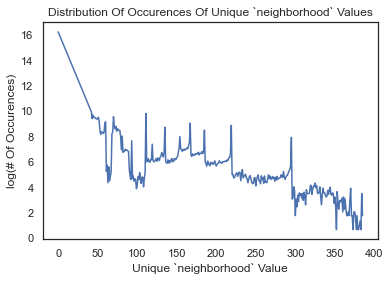

In [46]:
plt.plot(grouped_by_neighborhood.index, np.log(grouped_by_neighborhood.values.tolist()));
plt.xlabel("Unique `neighborhood` Value");
plt.ylabel("log(# Of Occurences)");
plt.title("Distribution Of Occurences Of Unique `neighborhood` Values");

- Most `neighborhood` values are very small and under 50.
- The higher the `neighborhood` value, the less it occurs.

### `coexpression`

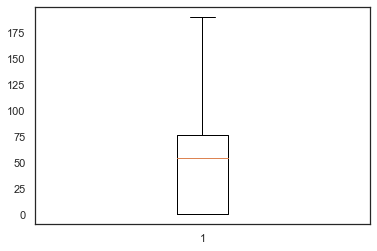

In [62]:
plt.boxplot(protein_links_v1.coexpression, showfliers=False);

### `cooccurence`

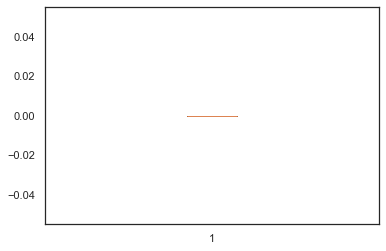

In [61]:
plt.boxplot(protein_links_v1.cooccurence, showfliers=False);

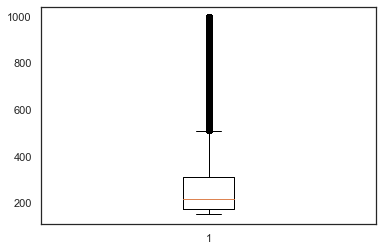

In [53]:
plt.boxplot(protein_links_v1.combined_score, showfliers=True);